# polly

Example notebook

Jake Pember
Updated 2024-11-15

This notebook demonstrates the basic use of the KPF etalon analysis code polly

---
### Dependencies

```
python >= 3.7
numpy
astropy
scipy
matplotlib
tqdm
```

---
### Imports

In [ ]:
from __future__ import annotations
from pathlib import Path

from matplotlib import pyplot as plt

try:
    from polly.etalonanalysis import Spectrum
    from polly.fileselection import find_L1_etalon_files
    from polly.plotStyle import plotStyle
except ImportError:
    from etalonanalysis import Spectrum
    from plotStyle import plotStyle
plt.style.use(plotStyle)

`polly` has a class structure of `Spectrum` <-> `Order` <-> `Peak` objects. All normal interfacing can be done at the `Spectrum` level, where functions initiate calls at lower levels, or access data from lower levels to be returned by the `Spectrum`.

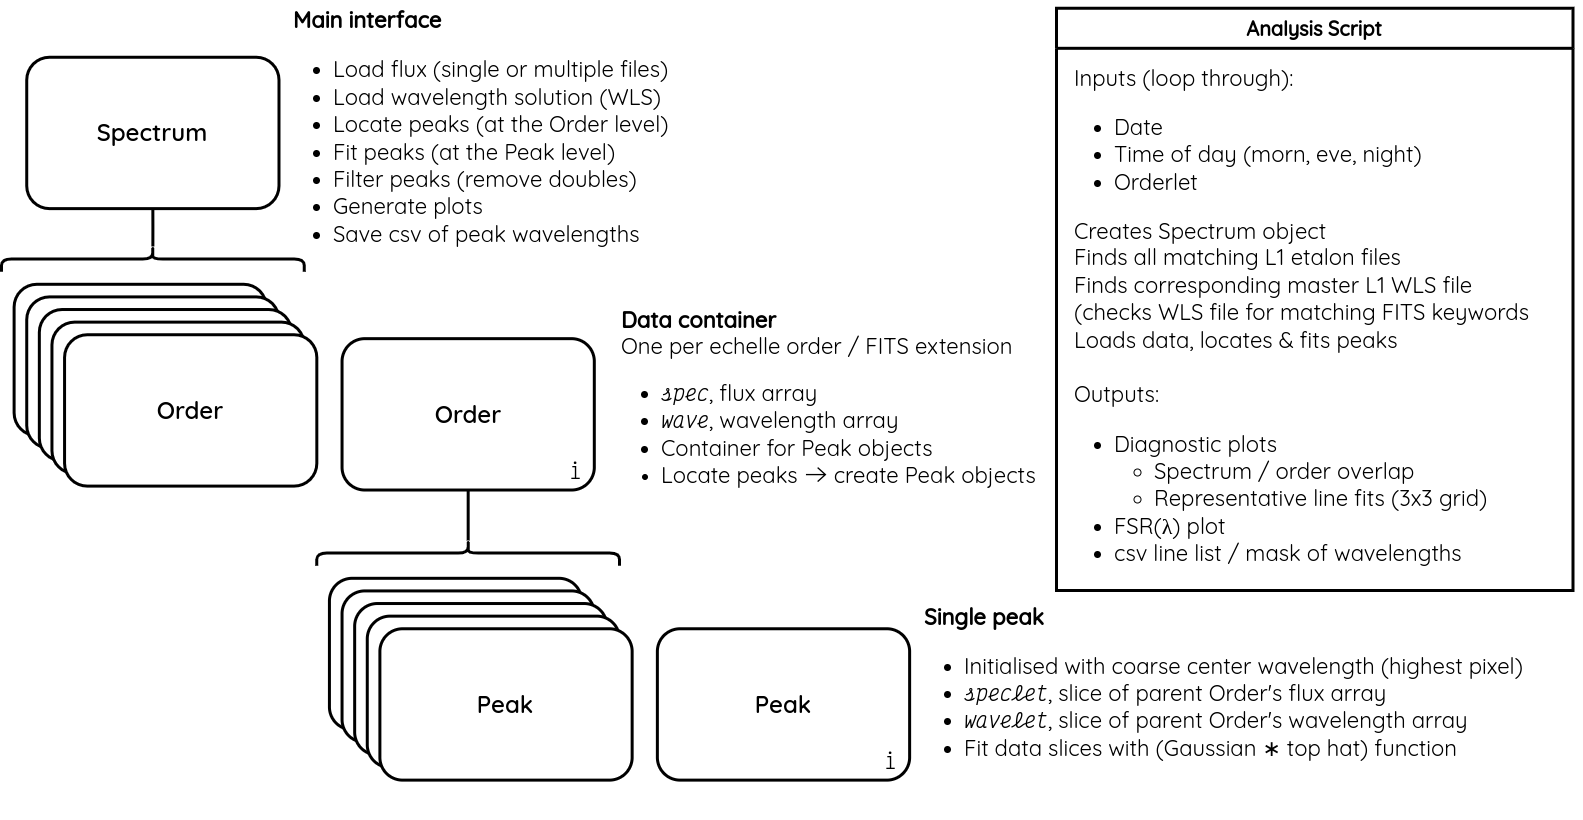

Set up all the master variables. These are nominally passed in within a `.cfg` file

In [3]:
OUTDIR: str = "/scr/jpember/temp"
# Make OUTDIR if it does not exist yet
Path(f"{OUTDIR}").mkdir(parents=True, exist_ok=True)

ORDERLETS: list[str] = [
    # "SCI1",
    "SCI2",
    # "SCI3",
    # "CAL",
    # "SKY",
    ]

DATES = [f"202405{x:02}" for x in range(1, 2)]
TIMESOFDAY: list[str] = [
    "morn",
    "eve",
    # "night",
    # "midnight",
    ]

---

### Batch processing example

This is adapted from the `run_analysis_batch.py` script

[20240501  morn]    Loading SCI2 flux values from a list of 9 files...
[20240501  morn]    Using WLS file: kpf_20240501_master_WLS_autocal-lfc-all-morn_L1.fits
[20240501  morn]    Locating SCI2 peaks...
[20240501  morn]    Fitting SCI2 peaks with conv_gauss_tophat function...
Orders: 100%|████████████████████████████████████████████████████| 67/67 [01:07<00:00,  1.00s/order]
[20240501  morn]    Filtering SCI2 peaks to remove identical peaks appearing in adjacent orders...
[20240501  morn]    Saving SCI2 peaks to /scr/jpember/temp/20240501_morn_SCI2_etalon_wavelengths.csv...
[20240501  morn]    Plotting SCI2 spectrum...
[20240501  morn]    Plotting SCI2 Etalon FSR...
[20240501  morn]    Plotting fits of SCI2 etalon peaks...
[20240501   eve]    Loading SCI2 flux values from a list of 6 files...
[20240501   eve]    Using WLS file: kpf_20240501_master_WLS_autocal-lfc-all-eve_L1.fits
[20240501   eve]    Locating SCI2 peaks...
[20240501   eve]    Fitting SCI2 peaks with conv_gauss_tophat fun

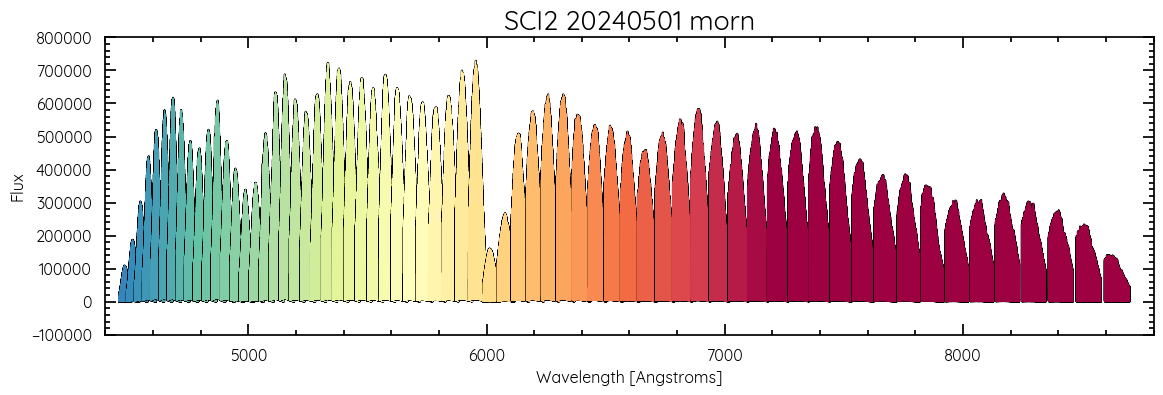

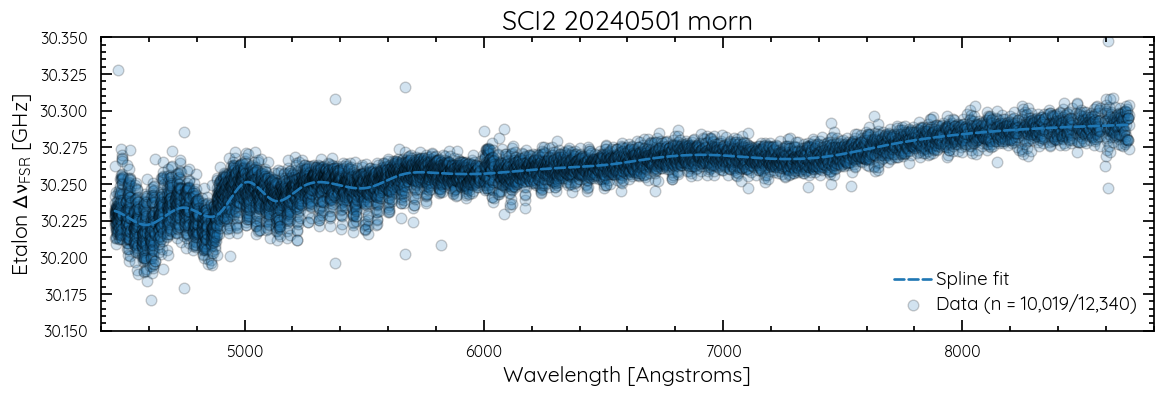

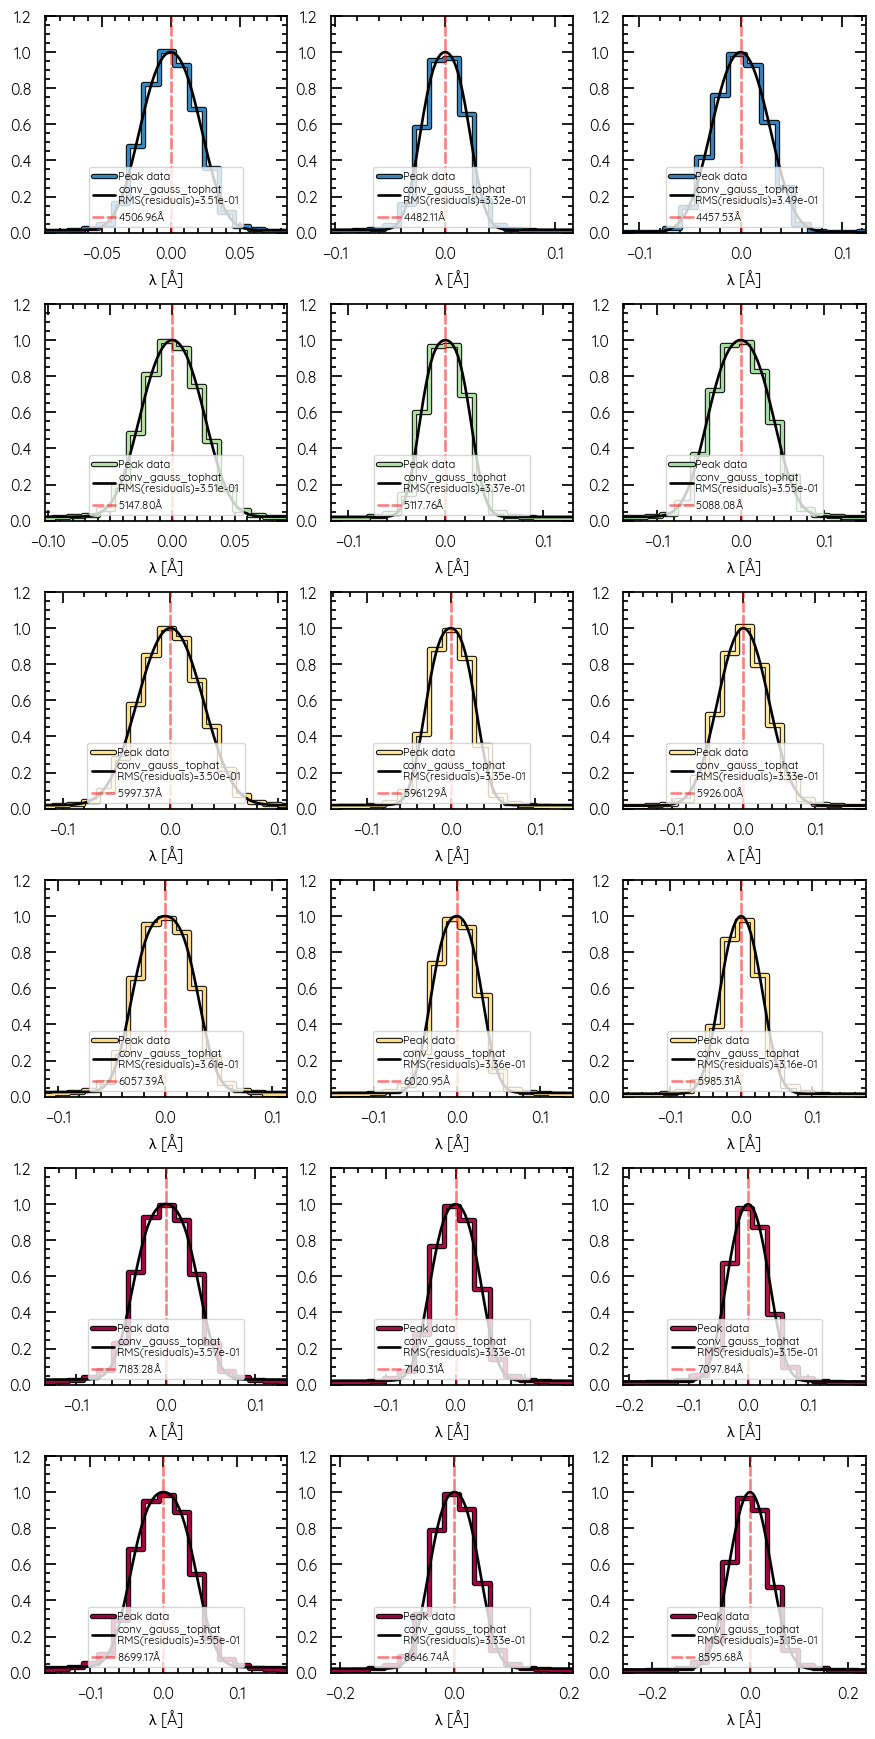

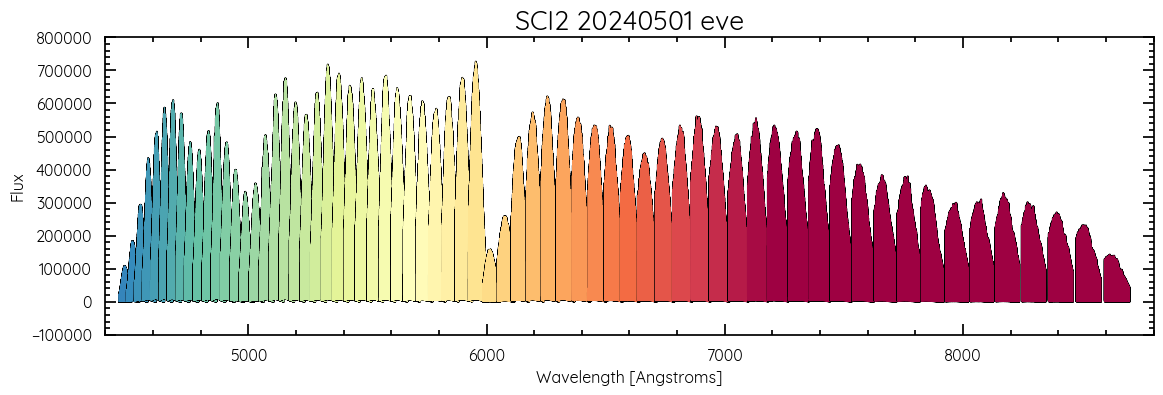

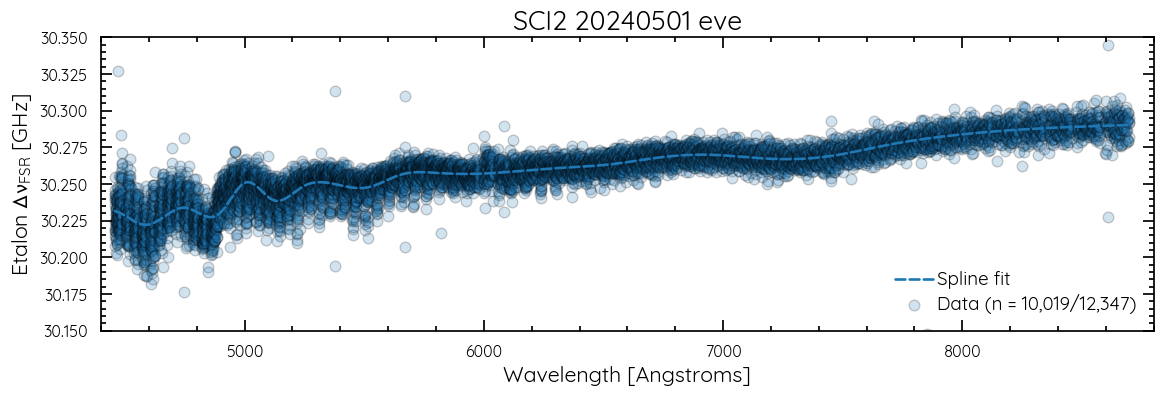

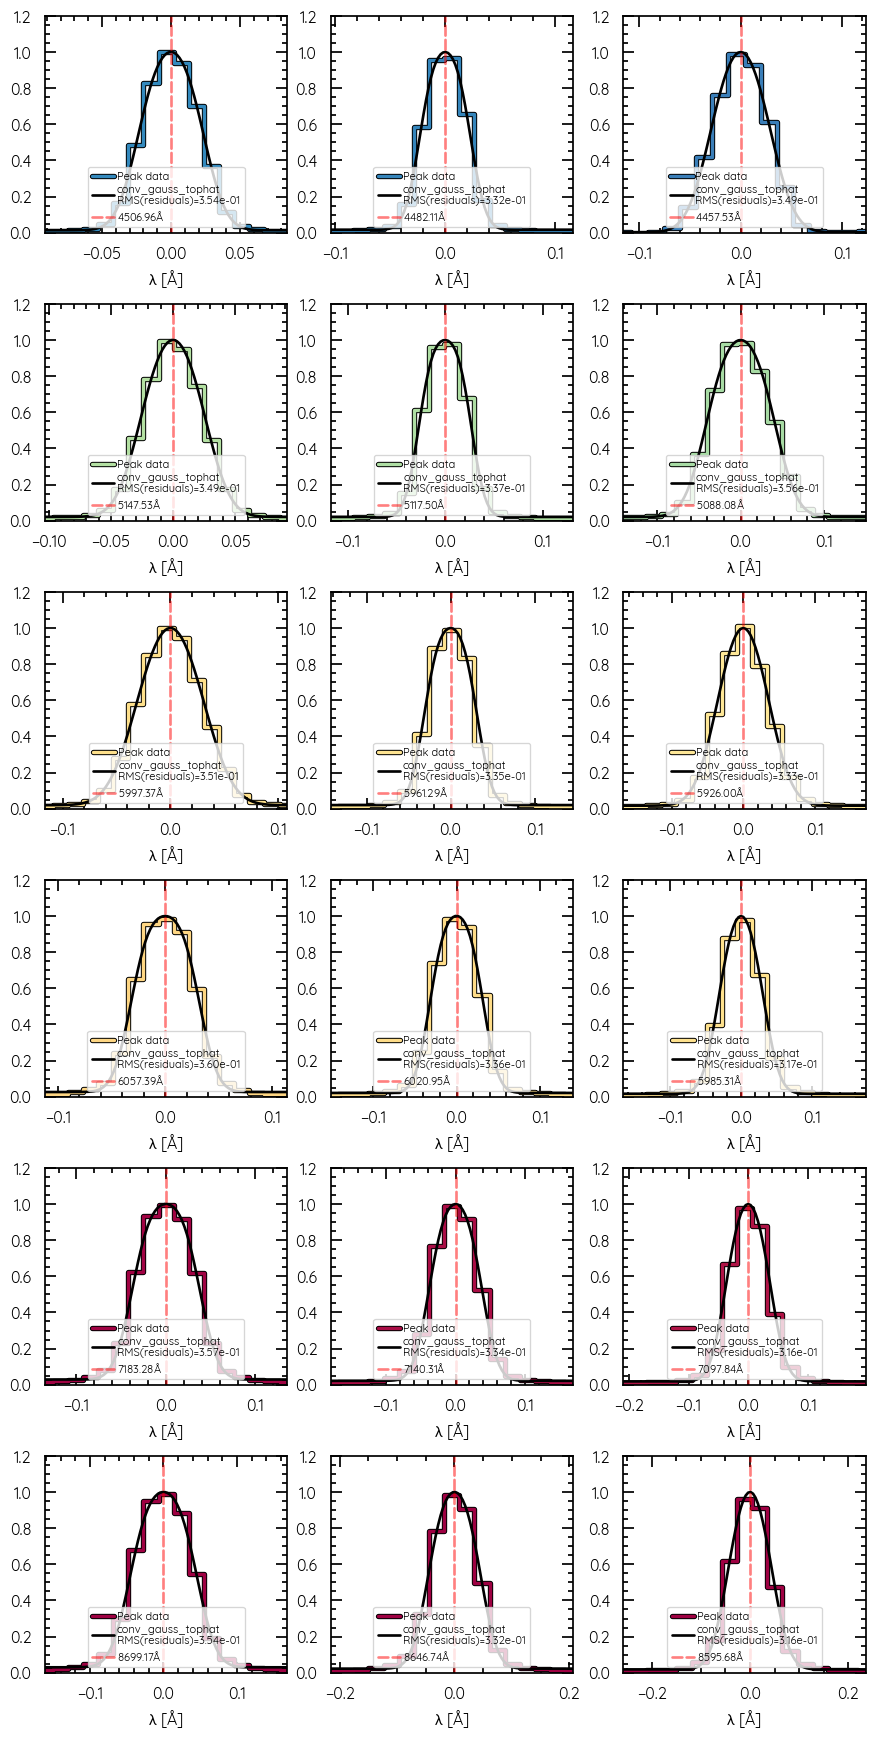

In [ ]:
for date in DATES:

    for timeofday in TIMESOFDAY:

        pp = f"{f'[{date} {timeofday:>5}]':<20}" # Print/logging line prefix

        files = find_L1_etalon_files(date=date, timeofday=timeofday, masters=False)
        if not files:
            print("No files found for {date} {timeofday}")
            continue

        s = Spectrum(
            spec_file = files,
            wls_file = None, # It will try to find the corresponding WLS file
            orderlets_to_load = ORDERLETS,
            pp = pp,
            )  
        s.locate_peaks()
        s.fit_peaks(type="conv_gauss_tophat")
        s.filter_peaks()
        
        for ol in s.orderlets:
            s.save_peak_locations(filename = f"{OUTDIR}/{date}_{timeofday}_{ol}_etalon_wavelengths.csv", orderlet = ol)

            s.plot_spectrum(orderlet=ol, plot_peaks=False)
            # plt.savefig(f"{OUTDIR}/spectrum_plots/"+\
            #     f"{date}_{timeofday}_{ol}_spectrum.png")
            # plt.close()

            s.plot_FSR(orderlet=ol)
            # plt.savefig(f"{OUTDIR}/FSR_plots/"+\
            #     f"{date}_{timeofday}_{ol}_etalon_FSR.png")
            # plt.close()
            
            s.plot_peak_fits(orderlet=ol)
            # plt.savefig(f"{OUTDIR}/fit_plots/"+\
            #     f"{date}_{timeofday}_{ol}_etalon_fits.png")
            # plt.close()

---

### Single-file processing example

The simpler way to run `polly` is for just a single file. Here a `Spectrum` object is created, and filenames for the `spec_file` and `wls_file` are passed in explicitly. This is how you can force the analysis to use a particular wavelength solution.

The `Spectrum` class's methods can also be chained. Each of the key methods returns the `Spectrum` object itself. For this reason, ending a notebook cell with some `Spectrum` method may result in a large output, and so you can just insert and empty string to prevent this.

In [6]:
# Load a particular master etalon file, and explicitly the corresponding WLS file 

DATE = "20240515"
TIMEOFDAY = "eve"
ORDERLET = "SCI2"

example_spec_file = f"/data/kpf/masters/{DATE}/kpf_{DATE}_master_WLS_autocal-etalon-all-{TIMEOFDAY}_L1.fits"
example_wls_file  = f"/data/kpf/masters/{DATE}/kpf_{DATE}_master_WLS_autocal-lfc-all-{TIMEOFDAY}_L1.fits"

s = Spectrum(spec_file=example_spec_file, wls_file=example_wls_file, orderlets_to_load=ORDERLET)
s.locate_peaks().fit_peaks().filter_peaks().save_peak_locations(filename=f"{OUTDIR}/test.csv", orderlet=ORDERLET)
""

Loading flux values from a single file: kpf_20240515_master_WLS_autocal-etalon-all-eve_L1.fits...


Locating SCI2 peaks...
Fitting SCI2 peaks with conv_gauss_tophat function...
Orders: 100%|████████████████████████████████████████████████████| 67/67 [01:06<00:00,  1.01order/s]
Filtering SCI2 peaks to remove identical peaks appearing in adjacent orders...
Saving SCI2 peaks to /scr/jpember/temp/test.csv...


''

Plotting SCI2 spectrum...


Spectrum(spec_file=/data/kpf/masters/20240515/kpf_20240515_master_WLS_autocal-etalon-all-eve_L1.fits, wls_file=/data/kpf/masters/20240515/kpf_20240515_master_WLS_autocal-lfc-all-eve_L1.fits, orderlets_to_load=['SCI2'])

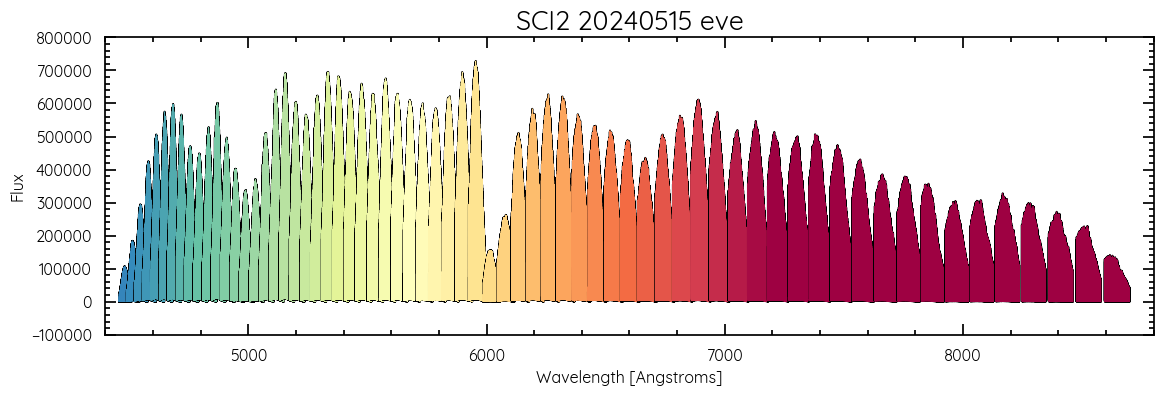

In [9]:
s.plot_spectrum(orderlet="SCI2", plot_peaks=False)

Plotting SCI2 Etalon FSR...


Spectrum(spec_file=/data/kpf/masters/20240515/kpf_20240515_master_WLS_autocal-etalon-all-eve_L1.fits, wls_file=/data/kpf/masters/20240515/kpf_20240515_master_WLS_autocal-lfc-all-eve_L1.fits, orderlets_to_load=['SCI2'])

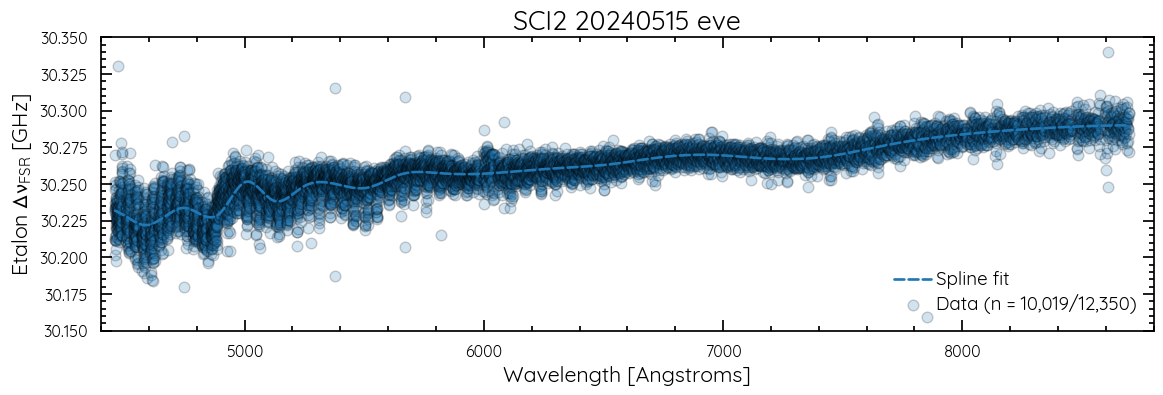

In [10]:
s.plot_FSR(orderlet="SCI2")

Plotting fits of SCI2 etalon peaks...


Spectrum(spec_file=/data/kpf/masters/20240515/kpf_20240515_master_WLS_autocal-etalon-all-eve_L1.fits, wls_file=/data/kpf/masters/20240515/kpf_20240515_master_WLS_autocal-lfc-all-eve_L1.fits, orderlets_to_load=['SCI2'])

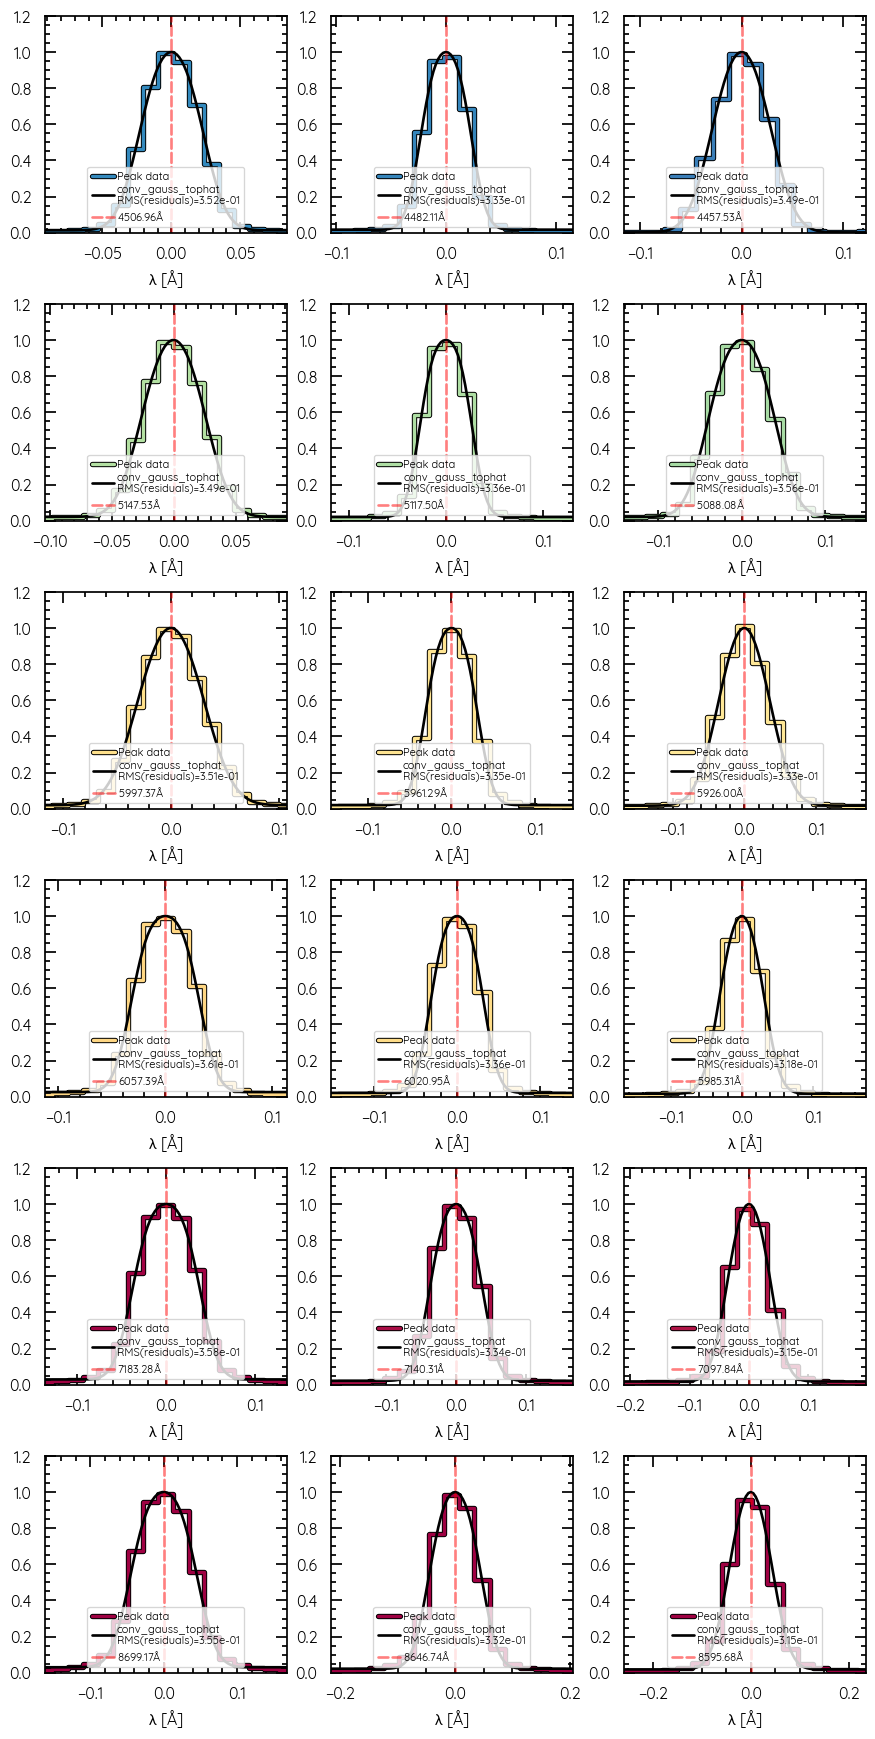

In [11]:
s.plot_peak_fits(orderlet="SCI2")